In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "7"
torch.cuda.device_count()

1

In [2]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
import torch
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

device = "cuda" if torch.cuda.is_available() else "cpu"

# get model
model = HookedTransformer.from_pretrained("google/gemma-2-2b", device = device)

layer = 15

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-scope-2b-pt-att-canonical",
    sae_id = f"layer_{layer}/width_16k/canonical",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

/proj/inductive-bias.shadow/abakalov.anaconda/envs/sae/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [01:38<00:00, 32.77s/it]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
blocks.15.attn.hook_z


In [3]:
from datasets import load_dataset 

dataset = load_dataset(
    "allenai/ai2_arc", "ARC-Easy",
    split="train",
    streaming=False,
)

def format_examples(examples) -> dict[str, list]:
    examples_formatted = {"sent": [],
                          "label": []}
    for example_question, example_choices, answer in zip(examples["question"], examples["choices"], examples["answerKey"]):
        have_correct_example, have_incorrect_example = False, False
        for choice, label in zip(example_choices["text"], example_choices["label"]):
            if label == answer and not have_correct_example:
                examples_formatted["sent"].append(example_question + " " + choice)
                examples_formatted["label"].append("True")
                have_correct_example = True
            elif not have_incorrect_example:
                examples_formatted["sent"].append(example_question + " " + choice)
                examples_formatted["label"].append("False")
                have_incorrect_example = True
    return examples_formatted

probing_dataset = dataset.map(format_examples, batched=True, batch_size=8, remove_columns=dataset.column_names)

print(len(probing_dataset))

probing_dataset = probing_dataset.shuffle(seed=42).select(range(500))
print(len(probing_dataset), len(probing_dataset.filter(lambda example: example["label"] == "True")))

4502
500 264


In [4]:
import numpy as np
from functools import partial

def tokenize(examples, column_name, tokenizer, max_length):
        tokenizer.padding_side = "right"
        text = examples[column_name]
        tokens = tokenizer(text, return_tensors="np", padding="longest", max_length=max_length)["input_ids"]
        len_of_input = np.argmax(tokens == tokenizer.pad_token_id, axis=1)
        assert (tokens[len_of_input == 0] != tokenizer.pad_token_id).all(), (len_of_input, tokens)
        len_of_input[len_of_input == 0] = tokens.shape[1]
        return {"tokens": tokens, "len_of_input": len_of_input}

tokenized_dataset = probing_dataset.map(
    partial(tokenize,
    column_name = "sent",
    tokenizer = model.tokenizer,
    max_length=sae.cfg.context_size),
    batched=True,
    batch_size=8,
    num_proc=None
)
tokenized_dataset.set_format(type="torch", columns=["tokens", "label", "len_of_input"])
tokenized_dataset[0]

{'label': 'False',
 'tokens': tensor([     2,  13033,   1134,   1546,   5476,    614,    573,  17930,    576,
            671,   4018,    675,    476,   2301,   6620,    578,   2910,   5182,
         235336,   3178,   5601,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]),
 'len_of_input': tensor(21)}

In [9]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

accuracies = {head: [] for head in range(8)}
num_of_features = {head: [] for head in range(8)}
for layer in range(0, 25):
    # get the SAE for this layer
    sae, cfg_dict, _ = SAE.from_pretrained(
        release = "gemma-scope-2b-pt-att-canonical",
        sae_id = f"layer_{layer}/width_16k/canonical",
        device = device
    )

    # get hook point
    hook_point = sae.cfg.hook_name

    sae.eval()  # prevents error if we're expecting a dead neuron mask for who grads

    correct_activations = {head: [] for head in range(8)}

    dataloader = DataLoader(tokenized_dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch_tokens = batch["tokens"]
            _, cache = model.run_with_cache(batch_tokens, prepend_bos=True)

            # feature_acts = sae.encode(cache[sae.cfg.hook_name])
            feature_acts = cache[sae.cfg.hook_name]
            for head in range(8):
                correct_activations[head].append(
                    feature_acts[np.arange(batch_tokens.shape[0]), batch["len_of_input"] - 1, head, :].detach().cpu())

            del cache

    for head in range(8):
        correct_activations_dataset = torch.vstack(correct_activations[head])

        X = correct_activations_dataset.numpy()
        y = np.array([1 if item["label"] == "True" else -1 for item in tokenized_dataset])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        lr = LogisticRegression(penalty="l1", solver="liblinear").fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        accuracies[head].append(accuracy_score(y_test, y_pred))
        num_of_features[head].append((lr.coef_ != 0).sum())

100%|██████████| 63/63 [00:17<00:00,  3.68it/s]


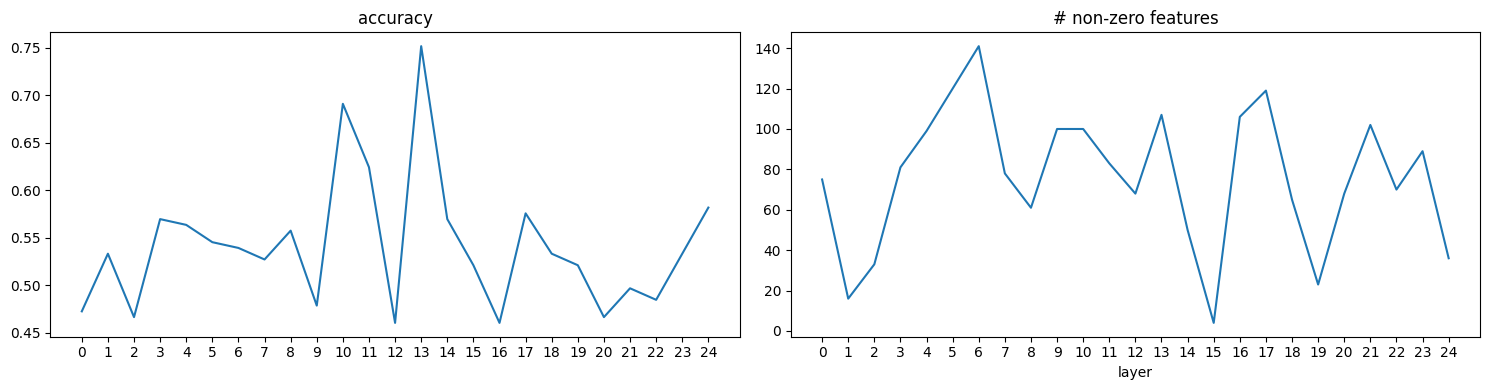

In [21]:
import matplotlib.pyplot as plt

head = 0

fig, axs = plt.subplots(1, 2)
fig.set_size_inches((15, 4))
axs[0].plot(accuracies[head])
axs[0].set_title("accuracy")

axs[1].plot(num_of_features[head])
axs[1].set_title("# non-zero features")

for i in range(2):
    axs[i].set_xticks(np.arange(len(accuracies[head])), labels=np.arange(len(accuracies[head])))
    if i == 1:
        axs[i].set_xlabel("layer")
fig.tight_layout()
plt.show()